In [1]:
import pandas as pd
import re
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from urllib.parse import urlparse
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import random

import time
from tqdm import tqdm



2023-11-20 00:59:58.344171: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/pranaymishra/Desktop/care/.conda/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
common_regex = '^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[^\]]+)\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-)'
combined_regex = '^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[^\]]+)\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-) "(?P<referrer>[^"]*)" "(?P<useragent>[^"]*)'
columns = ['client', 'userid', 'datetime', 'method', 'request', 'status', 'size', 'referer', 'user_agent']

In [3]:
def keep_data_percent(input_file, output_file):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    num_lines_to_keep = int(len(lines) * 0.001)

    kept_lines = lines[:num_lines_to_keep]

    with open(output_file, 'w') as f:
        f.writelines(kept_lines)

if __name__ == "__main__":
    input_file = "access.log"
    output_file = "new_file.log"

    keep_data_percent(input_file, output_file)


In [4]:
%mkdir parquet_dir

mkdir: parquet_dir: File exists


In [5]:

def logs_to_df(logfile, output_dir, errors_file):
    with open(logfile) as source_file:
        linenumber = 0
        parsed_lines = []
        for line in tqdm(source_file):
            try:
                log_line = re.findall(combined_regex, line)[0]
                parsed_lines.append(log_line)
            except Exception as e:
                with open(errors_file, 'at') as errfile:
                    print((line, str(e)), file=errfile)
                continue
            linenumber += 1
            if linenumber % 250_000 == 0:
                df = pd.DataFrame(parsed_lines, columns=columns)
                df.to_parquet(f'{output_dir}/file_{linenumber}.parquet')
                parsed_lines.clear()
        else:
            df = pd.DataFrame(parsed_lines, columns=columns)
            df.to_parquet(f'{output_dir}/file_{linenumber}.parquet')
            parsed_lines.clear()

In [6]:
logs_to_df(logfile='./new_file.log', output_dir='parquet_dir/', errors_file='errors.txt')

10365it [00:00, 174703.67it/s]


In [7]:
logs_df = pd.read_parquet('parquet_dir/')

In [8]:
logs_df['client'] = logs_df['client'].astype('category')
del logs_df['userid']
logs_df['datetime'] = pd.to_datetime(logs_df['datetime'], format='%d/%b/%Y:%H:%M:%S %z')
logs_df['method'] = logs_df['method'].astype('category')
logs_df['status'] = logs_df['status'].astype('int16')
logs_df['size'] = logs_df['size'].astype('int32')
logs_df['referer'] = logs_df['referer'].astype('category')
logs_df['user_agent'] = logs_df['user_agent'].astype('category')

In [9]:
logs_df

,client,datetime,method,request,status,size,referer,user_agent
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/60844/productModel/200x200,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/61474/productModel/200x200,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET,/image/14925/productModel/100x100,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
...,...,...,...,...,...,...,...,...
321306,85.10.206.20,2019-01-22 09:06:22+03:30,GET,/browse/etching-pot/%DA%AF%D9%84%D8%AF%D8%A7%25,200,30273,-,Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:...
321307,40.77.167.13,2019-01-22 09:06:22+03:30,GET,"/filter/b1,b103,b105,b109,b111,b113,b135,b144,...",200,38200,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
321308,91.99.30.32,2019-01-22 09:06:22+03:30,GET,/variationGroup/variationForm?baseProductId=20...,200,962,https://www.zanbil.ir/product/productDetails?c...,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...
321309,37.129.105.252,2019-01-22 09:06:22+03:30,GET,/image/11926?name=sm812aaa.jpg&wh=200x200,200,4377,-,Dalvik/2.1.0 (Linux; U; Android 7.1.2; Redmi N...


In [10]:
logs_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321311 entries, 0 to 321310
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype                    
---  ------      --------------   -----                    
 0   client      321311 non-null  category                 
 1   datetime    321311 non-null  datetime64[ns, UTC+03:30]
 2   method      321311 non-null  category                 
 3   request     321311 non-null  object                   
 4   status      321311 non-null  int16                    
 5   size        321311 non-null  int32                    
 6   referer     321311 non-null  category                 
 7   user_agent  321311 non-null  category                 
dtypes: category(4), datetime64[ns, UTC+03:30](1), int16(1), int32(1), object(1)
memory usage: 9.4+ MB


In [11]:
logs_df['referer'] = logs_df['referer'].str.lower()
def classify_traffic(referrer):
    if '-' in referrer and len(referrer) < 2:
        return 'direct'  
    elif any(keyword in referrer.lower() for keyword in ['google', 'bing', 'yahoo','yandex','baidu','torob','search']):
        return 'search'  
    elif any(keyword in referrer.lower() for keyword in ['facebook', 'twitter', 'linkedin','instagram','pinterest','youtube','reddit','ask','telegram']):
        return 'social'  
    else:
        return 'other'

    
logs_df['traffic-label'] = logs_df['referer'].apply(classify_traffic)

In [12]:
logs_df[logs_df['traffic-label'] == 'social'].head(10)

,client,datetime,method,request,status,size,referer,user_agent,traffic-label
4396,5.117.242.204,2019-01-22 04:13:22+03:30,GET,/settings/logo,200,4120,https://www.zanbil.ir/basket/view,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4397,5.117.242.204,2019-01-22 04:13:22+03:30,GET,/image/55839/productModel/100x100,200,2028,https://www.zanbil.ir/basket/view,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4429,5.117.242.204,2019-01-22 04:13:31+03:30,GET,/basket/checkout,200,18037,https://www.zanbil.ir/basket/view,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4433,5.117.242.204,2019-01-22 04:13:33+03:30,GET,/settings/logo,200,4120,https://www.zanbil.ir/basket/checkout,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4586,5.117.242.204,2019-01-22 04:14:16+03:30,GET,/basket/storeCustomerInformationWithoutRegistr...,302,0,https://www.zanbil.ir/basket/checkout,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4591,5.117.242.204,2019-01-22 04:14:17+03:30,GET,/basket/checkout?currentStep=2,200,20399,https://www.zanbil.ir/basket/checkout,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4601,5.117.242.204,2019-01-22 04:14:19+03:30,GET,/settings/logo,200,4120,https://www.zanbil.ir/basket/checkout?currents...,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4602,5.117.242.204,2019-01-22 04:14:20+03:30,GET,/basket/provinces?__amp_source_origin=https%3A...,200,444,https://www.zanbil.ir/basket/checkout?currents...,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4603,5.117.242.204,2019-01-22 04:14:20+03:30,GET,/basket/cities?__amp_source_origin=https%3A%2F...,200,389,https://www.zanbil.ir/basket/checkout?currents...,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social
4604,5.117.242.204,2019-01-22 04:14:20+03:30,GET,/province/json?__amp_source_origin=https%3A%2F...,200,5212,https://www.zanbil.ir/basket/checkout?currents...,Mozilla/5.0 (Linux; Android 7.0; Lenovo TB-730...,social


In [13]:
def extract_netloc(url):
    parsed_url = urlparse(url)
    return parsed_url.netloc
logs_df['ref'] = logs_df['referer'].apply(extract_netloc)
logs_df

,client,datetime,method,request,status,size,referer,user_agent,traffic-label,ref
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,200,30577,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,direct,
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/60844/productModel/200x200,200,5667,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,other,www.zanbil.ir
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/61474/productModel/200x200,200,5379,https://www.zanbil.ir/m/filter/b113,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,other,www.zanbil.ir
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET,/image/14925/productModel/100x100,200,1696,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,direct,
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200,41483,-,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,direct,
...,...,...,...,...,...,...,...,...,...,...
321306,85.10.206.20,2019-01-22 09:06:22+03:30,GET,/browse/etching-pot/%DA%AF%D9%84%D8%AF%D8%A7%25,200,30273,-,Mozilla/5.0 (compatible; MJ12bot/v1.4.8; http:...,direct,
321307,40.77.167.13,2019-01-22 09:06:22+03:30,GET,"/filter/b1,b103,b105,b109,b111,b113,b135,b144,...",200,38200,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,direct,
321308,91.99.30.32,2019-01-22 09:06:22+03:30,GET,/variationGroup/variationForm?baseProductId=20...,200,962,https://www.zanbil.ir/product/productdetails?c...,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,other,www.zanbil.ir
321309,37.129.105.252,2019-01-22 09:06:22+03:30,GET,/image/11926?name=sm812aaa.jpg&wh=200x200,200,4377,-,Dalvik/2.1.0 (Linux; U; Android 7.1.2; Redmi N...,direct,


In [14]:
threshold = 75 
logs_df['refers'] = ''

def compare_urls(url1, url2):
    return fuzz.ratio(url1, url2)
canonical_urls = {}

for idx, url in enumerate(logs_df['ref']):
    canonical_url = None
    for key, value in canonical_urls.items():
        if compare_urls(url, key) >= threshold:
            canonical_url = key
            break
    
    if canonical_url is None:
        canonical_url = url
        canonical_urls[canonical_url] = canonical_url
    
    logs_df.at[idx, 'refers'] = canonical_url


In [15]:
logs_df['refers'].value_counts()

refers
www.zanbil.ir                              195216
                                           106472
znbl.ir                                     10969
torob.com                                    3220
www-zanbil-ir.cdn.ampproject.org             2343
www.google.com                               2134
ptcnovin.com                                  238
emalls.ir                                     205
arzoonyab.com                                 128
www.ask.ir                                     94
com.google.android.googlequicksearchbox        70
irantradeco.ir                                 40
www.webgardii.ir                               21
www.khanesazan.com                             20
www.homepars.com                               16
com.google.android.gm                          12
www.bing.com                                   11
gahar.ir                                       10
newsboxi.ir                                    10
www.zamoune.com                            

In [16]:
url_counts = logs_df['refers'].value_counts()

less_than_10_counts = url_counts[url_counts < 10]

unique_urls_less_than_10 = len(less_than_10_counts)
print("UNIQUE URLS LESS THAN 10:", unique_urls_less_than_10)
logs_df = logs_df[logs_df['refers'].isin(less_than_10_counts.index) == False]
print(unique_urls_less_than_10)

UNIQUE URLS LESS THAN 10: 28
28


In [17]:
url_counts = logs_df['ref'].value_counts()

more_than_10_counts = url_counts[url_counts > 500]

unique_urls_more_than_10 = more_than_10_counts.index.tolist()
print("UNIQUE URLS MORE THAN 10:", len(unique_urls_more_than_10))
print(unique_urls_more_than_10)

UNIQUE URLS MORE THAN 10: 6
['www.zanbil.ir', '', 'znbl.ir', 'torob.com', 'www-zanbil-ir.cdn.ampproject.org', 'www.google.com']


In [18]:
threshold = 25 
logs_df['user-agent'] = ''
logs_df['user_agent'] = logs_df['user_agent'].str.lower()
def compare_urls(url1, url2):
    return fuzz.ratio(url1, url2)
canonical_urls = {}

for idx, url in enumerate(logs_df['user_agent']):
    canonical_url = None
    for key, value in canonical_urls.items():
        if compare_urls(url, key) >= threshold:
            canonical_url = key
            break
    
    if canonical_url is None:
        canonical_url = url
        canonical_urls[canonical_url] = canonical_url
    
    logs_df.at[idx, 'user-agent'] = canonical_url

/var/folders/0d/srwhm0y53j14k9ypbh_kj7v40000gn/T/ipykernel_17878/1997143466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_df['user-agent'] = ''
/var/folders/0d/srwhm0y53j14k9ypbh_kj7v40000gn/T/ipykernel_17878/1997143466.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_df['user_agent'] = logs_df['user_agent'].str.lower()
/var/folders/0d/srwhm0y53j14k9ypbh_kj7v40000gn/T/ipykernel_17878/1997143466.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [19]:
logs_df['user-agent'].value_counts()

user-agent
mozilla/5.0 (compatible; ahrefsbot/6.1; +http://ahrefs.com/robot/)                                                                                271976
mozilla/5.0 (linux; android 6.0; ale-l21 build/huaweiale-l21) applewebkit/537.36 (khtml, like gecko) chrome/66.0.3359.158 mobile safari/537.36     44565
googlebot-image/1.0                                                                                                                                 2698
-                                                                                                                                                   1057
torob/5 cfnetwork/976 darwin/18.2.0                                                                                                                  910
                                                                                                                                                      82
curl/7.16.3 (amd64-portbld-freebsd7.0) libcurl/7.16.3 openssl/0.9.8e zl

In [20]:
encoder = LabelEncoder()
logs_df.loc[:, 'encoded_refers'] = encoder.fit_transform(logs_df['refers'])

unique_codes = logs_df['encoded_refers'].unique()
num_unique_urls = len(unique_codes)
print("Уникальные коды:", unique_codes)
print("Количество уникальных URL-адресов:", num_unique_urls)

Уникальные коды: [ 0 17 10  9  8 18 13  4  3 11  7 12  6 14  5 15  2 16  1 19]
Количество уникальных URL-адресов: 20


In [21]:
logs_df.loc[:, 'encoded_user-agent'] = encoder.fit_transform(logs_df['user-agent'])
logs_df.loc[:, 'encoded_status'] = encoder.fit_transform(logs_df['status'])
logs_df.loc[:, 'encoded_method'] = encoder.fit_transform(logs_df['method'])
logs_df['traffic-label'] = encoder.fit_transform(logs_df['traffic-label'])
print(logs_df['traffic-label'].value_counts())

traffic-label
1    203206
0    106472
2     10274
3      1277
4        82
Name: count, dtype: int64


In [22]:
logs_df = logs_df.dropna()

In [23]:
logs_df.isnull().sum()

client                0
datetime              0
method                0
request               0
status                0
size                  0
referer               0
user_agent            0
traffic-label         0
ref                   0
refers                0
user-agent            0
encoded_refers        0
encoded_user-agent    0
encoded_status        0
encoded_method        0
dtype: int64

In [24]:
logs_df

,client,datetime,method,request,status,size,referer,user_agent,traffic-label,ref,refers,user-agent,encoded_refers,encoded_user-agent,encoded_status,encoded_method
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,200.0,30577.0,-,mozilla/5.0 (compatible; ahrefsbot/6.1; +http:...,0,,,mozilla/5.0 (compatible; ahrefsbot/6.1; +http:...,0,6,0,0
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/60844/productModel/200x200,200.0,5667.0,https://www.zanbil.ir/m/filter/b113,mozilla/5.0 (linux; android 6.0; ale-l21 build...,1,www.zanbil.ir,www.zanbil.ir,mozilla/5.0 (linux; android 6.0; ale-l21 build...,17,7,0,0
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET,/image/61474/productModel/200x200,200.0,5379.0,https://www.zanbil.ir/m/filter/b113,mozilla/5.0 (linux; android 6.0; ale-l21 build...,1,www.zanbil.ir,www.zanbil.ir,mozilla/5.0 (linux; android 6.0; ale-l21 build...,17,7,0,0
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET,/image/14925/productModel/100x100,200.0,1696.0,-,mozilla/5.0 (compatible; bingbot/2.0; +http://...,0,,,mozilla/5.0 (compatible; ahrefsbot/6.1; +http:...,0,6,0,0
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,200.0,41483.0,-,mozilla/5.0 (windows nt 6.2; win64; x64; rv:16...,0,,,mozilla/5.0 (compatible; ahrefsbot/6.1; +http:...,0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321306,85.10.206.20,2019-01-22 09:06:22+03:30,GET,/browse/etching-pot/%DA%AF%D9%84%D8%AF%D8%A7%25,200.0,30273.0,-,mozilla/5.0 (compatible; mj12bot/v1.4.8; http:...,0,,,,0,0,0,0
321307,40.77.167.13,2019-01-22 09:06:22+03:30,GET,"/filter/b1,b103,b105,b109,b111,b113,b135,b144,...",200.0,38200.0,-,mozilla/5.0 (compatible; bingbot/2.0; +http://...,0,,,,0,0,0,0
321308,91.99.30.32,2019-01-22 09:06:22+03:30,GET,/variationGroup/variationForm?baseProductId=20...,200.0,962.0,https://www.zanbil.ir/product/productdetails?c...,mozilla/5.0 (windows nt 10.0; win64; x64; rv:6...,1,www.zanbil.ir,www.zanbil.ir,,17,0,0,0
321309,37.129.105.252,2019-01-22 09:06:22+03:30,GET,/image/11926?name=sm812aaa.jpg&wh=200x200,200.0,4377.0,-,dalvik/2.1.0 (linux; u; android 7.1.2; redmi n...,0,,,,0,0,0,0


In [25]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


In [26]:
features = [
    'encoded_refers', 'encoded_user-agent', 'encoded_status', 'encoded_method'
]

In [27]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(logs_df[features])

In [28]:
isolation_model = IsolationForest(contamination=0.05, random_state=42)
isolation_model.fit(scaled_data)

IsolationForest(contamination=0.05, random_state=42)

In [29]:
import matplotlib.pyplot as plt

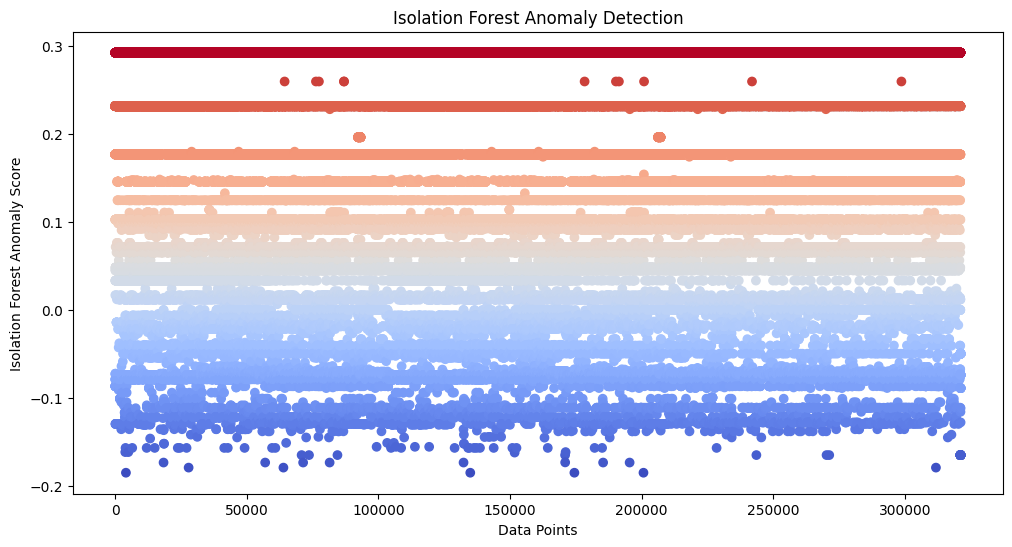

In [30]:
isolation_scores = isolation_model.decision_function(scaled_data)


plt.figure(figsize=(12, 6))
plt.scatter(range(len(scaled_data)), isolation_scores, c=isolation_scores, cmap='coolwarm')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Data Points')
plt.ylabel('Isolation Forest Anomaly Score')
plt.show()

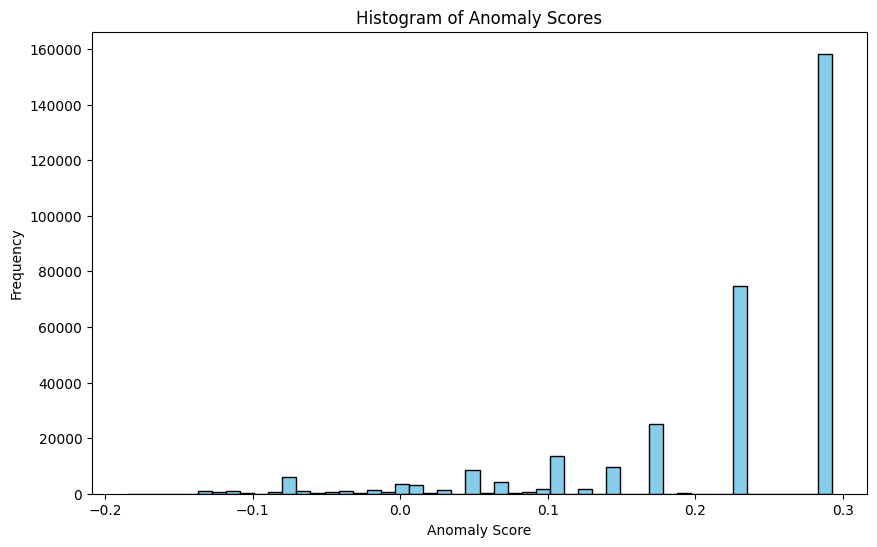

In [31]:
plt.figure(figsize=(10, 6))
plt.hist(isolation_scores, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()


In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM

# Fit One-Class SVM model
svm_model = OneClassSVM(kernel='linear', nu=0.05, n_jobs=-1)


svm_model.fit(scaled_data)

# Generate decision function scores
svm_decision = svm_model.decision_function(scaled_data)

# Visualize SVM decision scores
plt.figure(figsize=(12, 6))
plt.scatter(range(len(scaled_data)), svm_decision, c=svm_decision, cmap='coolwarm')
plt.title('SVM Anomaly Detection')
plt.xlabel('Data Points')
plt.ylabel('SVM Decision Score')
plt.show()


TypeError: OneClassSVM.__init__() got an unexpected keyword argument 'n_jobs'

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPRegressor

# Features for the model
features = ['encoded_refers', 'encoded_user-agent', 'encoded_status', 'encoded_method']

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(logs_df[features])

# Split the data into training and testing sets
X_train, X_test = train_test_split(scaled_data, test_size=0.2, random_state=42)

# Build the autoencoder model
autoencoder = MLPRegressor(hidden_layer_sizes=(10,), activation='relu', solver='adam', random_state=42)
autoencoder.fit(X_train, X_train)

# Reconstruct the data and calculate reconstruction error
reconstructed_data = autoencoder.predict(X_test)
mse = ((X_test - reconstructed_data) ** 2).mean(axis=1)

# Set a threshold for anomaly detection (adjust as needed)
threshold = 0.1

# Assuming 'logs_df' is your DataFrame
logs_df['anomaly_autoencoder'] = mse > threshold

# Check for missing values in 'logs_df' or 'mse'
print("Missing values in logs_df:", logs_df.isnull().sum())
print("Missing values in mse:", np.isnan(mse).sum())

# Evaluate the Autoencoder model
print(classification_report(logs_df['traffic-label'], logs_df['anomaly_autoencoder']))

ValueError: Length of values (64246) does not match length of index (321229)

In [35]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report

# Features for the model
features = ['encoded_refers', 'encoded_user-agent', 'encoded_status', 'encoded_method']

# Create and train the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
logs_df['anomaly_lof'] = lof.fit_predict(logs_df[features])

# Convert LOF predictions to binary (1 for normal, -1 for anomaly)
logs_df['anomaly_lof'] = (logs_df['anomaly_lof'] == 1)

# Evaluate the LOF model
print(classification_report(logs_df['traffic-label'], logs_df['anomaly_lof']))


/Users/pranaymishra/Desktop/care/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pranaymishra/Desktop/care/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.20      0.00      0.00    106472
           1       0.63      1.00      0.77    203206
           2       0.00      0.00      0.00     10274
           3       0.00      0.00      0.00      1277

    accuracy                           0.63    321229
   macro avg       0.21      0.25      0.19    321229
weighted avg       0.47      0.63      0.49    321229



/Users/pranaymishra/Desktop/care/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: 'c' argument has 64246 elements, which is inconsistent with 'x' and 'y' with size 321229.

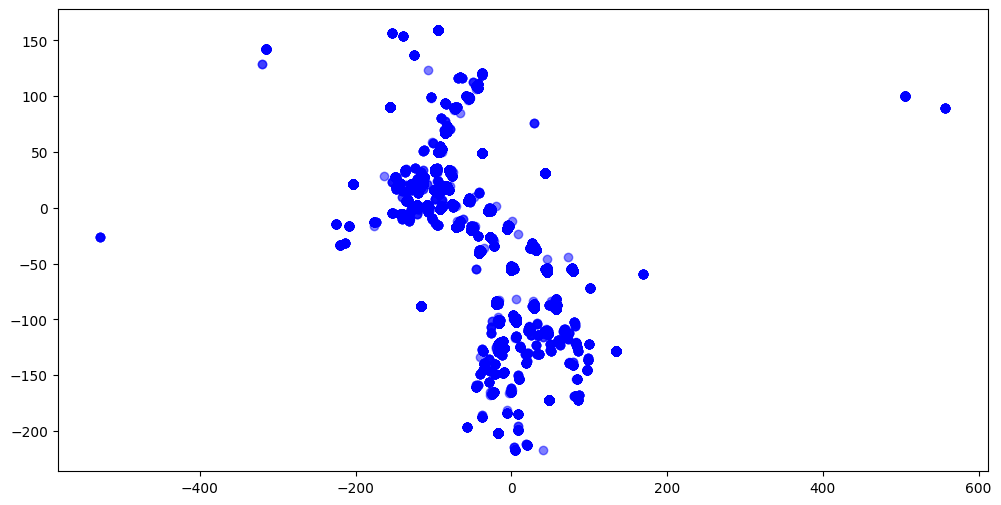

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(scaled_data)

# Plot original vs. reconstructed data
plt.figure(figsize=(12, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', label='Original Data', alpha=0.5)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=mse, cmap='Reds', label='Reconstructed Data (Anomalies)', alpha=0.5)
plt.title('Autoencoder: Original vs. Reconstructed Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


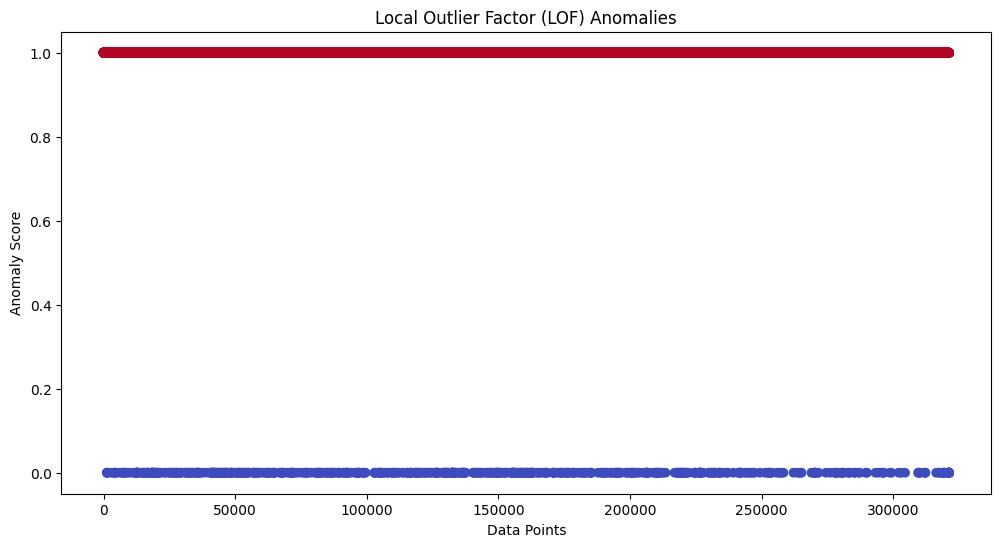

In [36]:
import matplotlib.pyplot as plt

# Visualize LOF scores
plt.figure(figsize=(12, 6))
plt.scatter(range(len(logs_df)), logs_df['anomaly_lof'], c=logs_df['anomaly_lof'], cmap='coolwarm')
plt.title('Local Outlier Factor (LOF) Anomalies')
plt.xlabel('Data Points')
plt.ylabel('Anomaly Score')
plt.show()


/Users/pranaymishra/Desktop/care/.conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


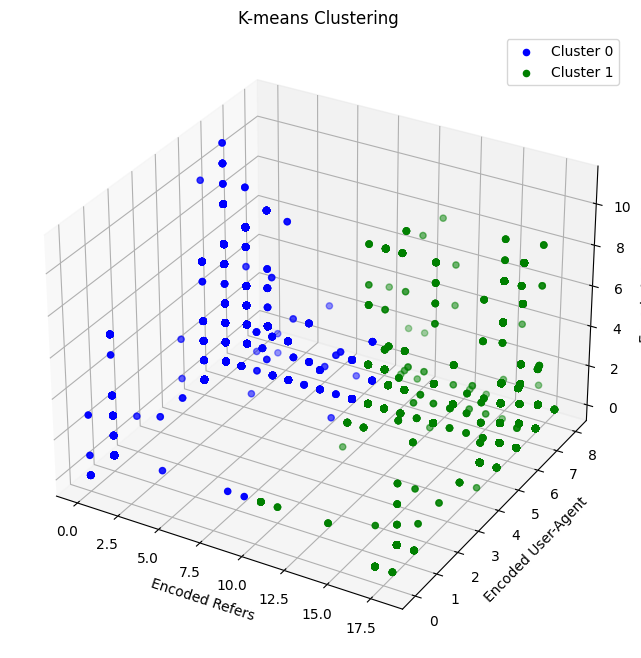

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report

# Features for the model
features = ['encoded_refers', 'encoded_user-agent', 'encoded_status', 'encoded_method']

# Create and train the K-means clustering model
kmeans = KMeans(n_clusters=2, random_state=42)
logs_df['cluster'] = kmeans.fit_predict(logs_df[features])

# Identify anomalies based on cluster membership
anomaly_cluster = logs_df['cluster'].value_counts().idxmin()
logs_df['anomaly_kmeans'] = logs_df['cluster'] == anomaly_cluster

# Visualize K-means clusters in 3D (example assumes 3 clusters)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['blue', 'green', 'red']

for cluster, color in zip(range(2), colors):
    cluster_data = logs_df[logs_df['cluster'] == cluster]
    ax.scatter(cluster_data['encoded_refers'], cluster_data['encoded_user-agent'], cluster_data['encoded_status'],
               c=color, label=f'Cluster {cluster}')

ax.set_xlabel('Encoded Refers')
ax.set_ylabel('Encoded User-Agent')
ax.set_zlabel('Encoded Status')
ax.set_title('K-means Clustering')
ax.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the datetime column as the index for time series analysis
logs_df.set_index('datetime', inplace=True)

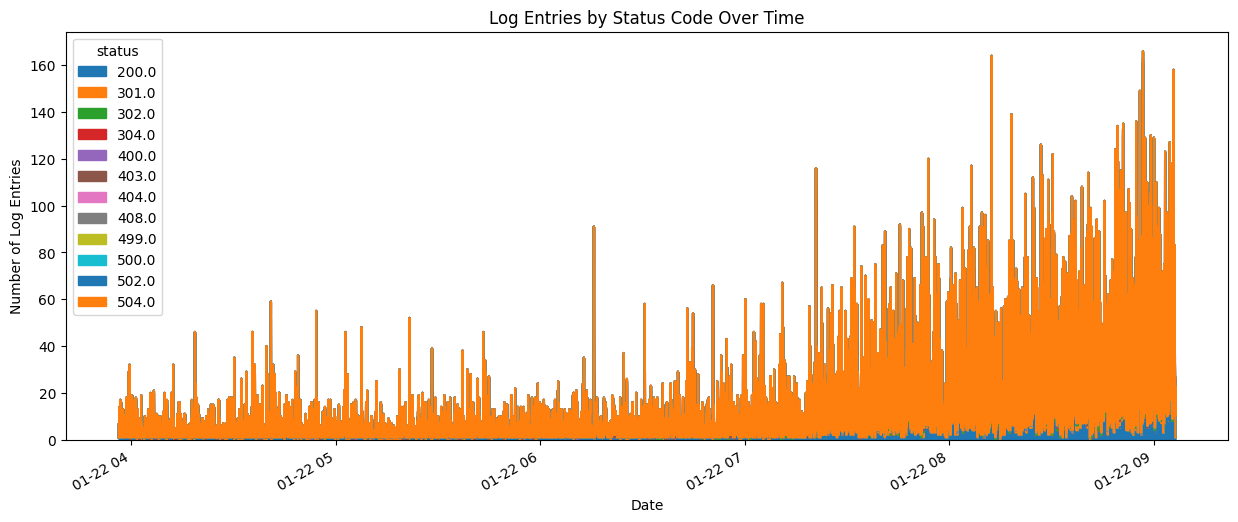

In [ ]:
status_counts = logs_df.groupby(['datetime', 'status']).size().unstack().fillna(0)
status_counts.plot.area(figsize=(15, 6), stacked=True)
plt.title('Log Entries by Status Code Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Log Entries')
plt.show()

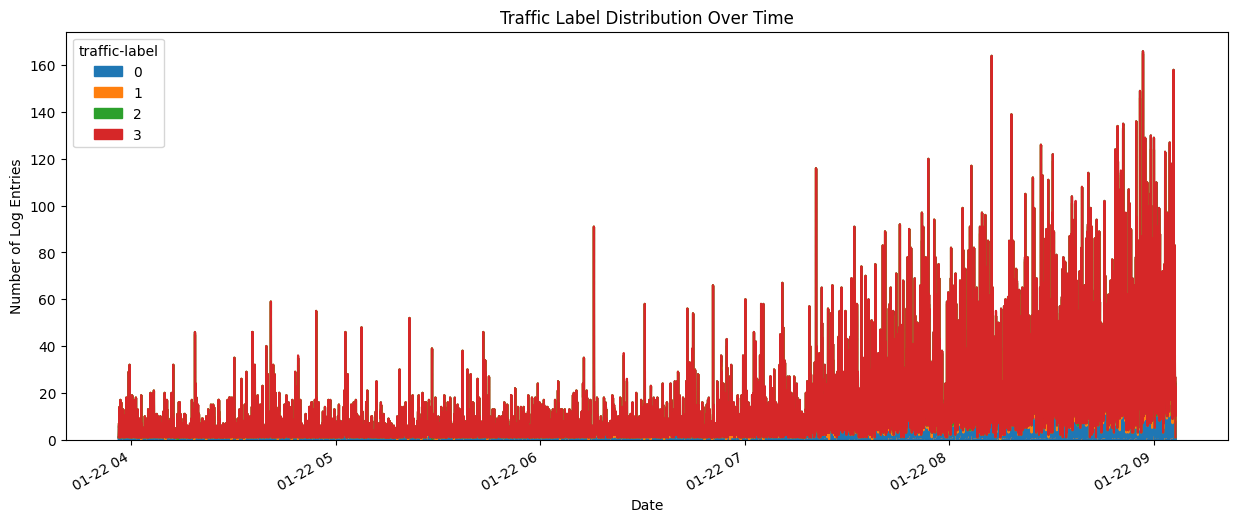

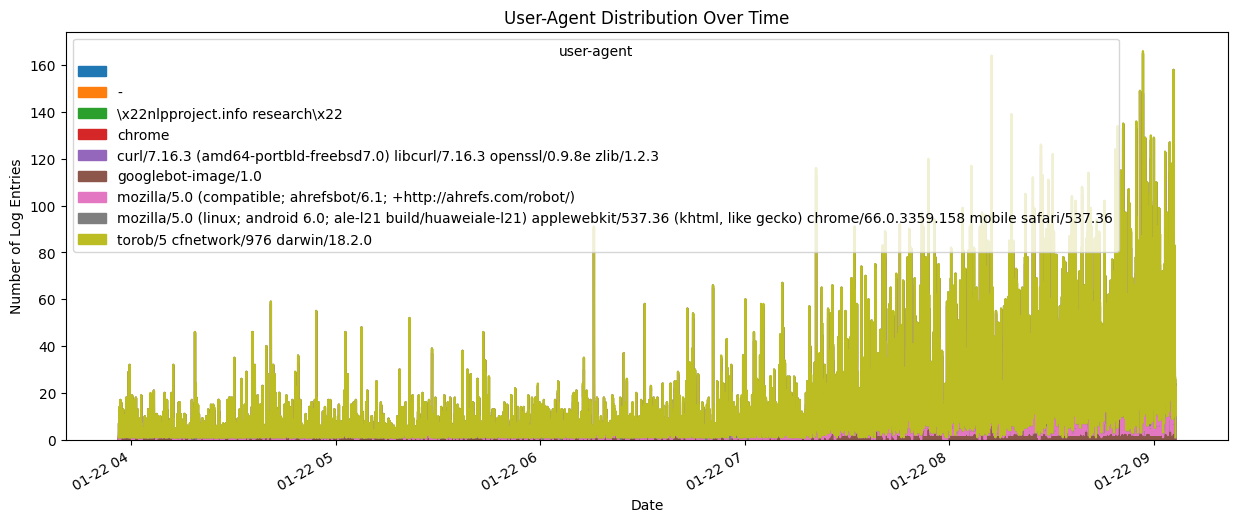

In [ ]:
traffic_label_counts = logs_df.groupby(['datetime', 'traffic-label']).size().unstack().fillna(0)
traffic_label_counts.plot.area(figsize=(15, 6), stacked=True)
plt.title('Traffic Label Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Log Entries')
plt.show()

# Analyze user-agent distribution over time
user_agent_counts = logs_df.groupby(['datetime', 'user-agent']).size().unstack().fillna(0)
user_agent_counts.plot.area(figsize=(15, 6), stacked=True)
plt.title('User-Agent Distribution Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Log Entries')
plt.show()